**Questions:**

Optimize volume, rate of acceptance, and probability of attending

- Where should we flier at what times, to distribute the most number fliers out there? 
    - Ranked list of locations
- Which locations with optimal clientele? 

**Data cleaning:**

- Duplicate, unnecessary data
- Inconsistent text, or typos
- Missing data
- Outliers

**To do:** 

- Rename EXITS column with str
- Combine entries and exits for cumulative volume

**Ways to visualize data:**

- Group by station, heatmap of average volume each hour
- Add toa map based on station, dot plots

In [82]:
import pandas as pd
import matplotlib as plt

df = pd.read_csv("Data/turnstile_190921.txt")
df.rename(columns={df.columns[10]:'EXITS'})

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,00:00:00,REGULAR,7198818,2438323
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,04:00:00,REGULAR,7198834,2438325
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,08:00:00,REGULAR,7198847,2438354
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,12:00:00,REGULAR,7198929,2438428
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,16:00:00,REGULAR,7199125,2438483
...,...,...,...,...,...,...,...,...,...,...,...
204923,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/20/2019,05:00:00,REGULAR,5554,420
204924,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/20/2019,09:00:00,REGULAR,5554,420
204925,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/20/2019,13:00:00,REGULAR,5554,420
204926,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/20/2019,17:00:00,REGULAR,5554,420


In [83]:
df.dtypes

C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                  int64
EXITS                                                                    int64
dtype: object

In [84]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,00:00:00,REGULAR,7198818,2438323
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,04:00:00,REGULAR,7198834,2438325
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,08:00:00,REGULAR,7198847,2438354
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,12:00:00,REGULAR,7198929,2438428
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/14/2019,16:00:00,REGULAR,7199125,2438483


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204928 entries, 0 to 204927
Data columns (total 11 columns):
C/A                                                                     204928 non-null object
UNIT                                                                    204928 non-null object
SCP                                                                     204928 non-null object
STATION                                                                 204928 non-null object
LINENAME                                                                204928 non-null object
DIVISION                                                                204928 non-null object
DATE                                                                    204928 non-null object
TIME                                                                    204928 non-null object
DESC                                                                    204928 non-null object
ENTRIES                           

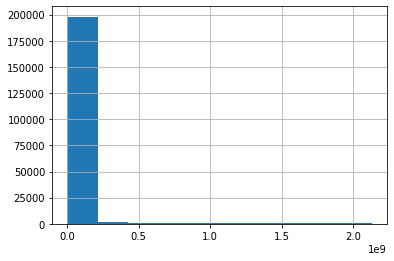

In [86]:
df['ENTRIES'].hist()

In [30]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [27]:
df['EXITS'].hist()

KeyError: 'EXITS'

In [23]:
plt.scatter(df['ENTRIES'],df['EXITS'])

AttributeError: module 'matplotlib' has no attribute 'scatter'

In [15]:
df.describe()

,ENTRIES,EXITS
count,2.049280e+05,2.049280e+05
mean,4.210505e+07,3.487423e+07
std,2.155757e+08,1.995488e+08
min,0.000000e+00,0.000000e+00
25%,2.898092e+05,1.294348e+05
50%,2.040950e+06,1.179450e+06
75%,6.618936e+06,4.535505e+06
max,2.129093e+09,2.123772e+09


/Users/collindching/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


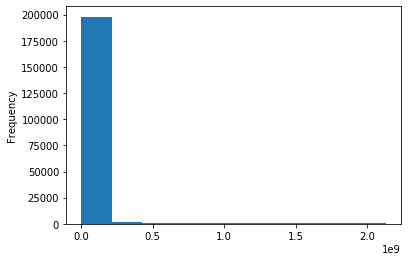

In [19]:
df['ENTRIES'].plot('hist')

In [ ]:
# Outliers


In [8]:
# No missing values
df.isnull().sum()

C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [42]:
# make a barplot with the means 
df.groupby('STATION')['ENTRIES'].mean()

AttributeError: module 'matplotlib' has no attribute 'barplot'

In [ ]:
# also make a boxplot